# 13 モデルの検証方法とチューニング方法

教師あり学習によって構築されるモデルは、未知のデータに適用したときに、モデル構築者の期待する性能を発揮することが重要です。本章では、この未知データに対するモデル性能（汎化性能）を評価するためのモデルの検証方法を学びます。また、そもそもの汎化性能を向上させるためのアプローチについても学びます。

- **[13.1 モデルの評価とパフォーマンスチューニング](#13.1-モデルの評価とパフォーマンスチューニング)** 
    - [13.1.1 ホールドアウト法と交差検証法](#13.1.1-ホールドアウト法と交差検証法)
    - [13.1.2 パフォーマンスチューニング：ハイパーパラメータチューニング](#13.1.2-パフォーマンスチューニング：ハイパーパラメータチューニング)
    - [13.1.3 パフォーマンスチューニング：特徴量の扱い](#13.1.3-パフォーマンスチューニング：特徴量の扱い)
    - [13.1.4 モデルの種類](#13.1.4-モデルの種類)
<br><br> 
- **[13.2 モデルの評価指標](#13.2-モデルの評価指標)** 
    - [13.2.1 分類モデルの評価：混同行列と関連指標](#13.2.1-分類モデルの評価：混同行列と関連指標)
    - [13.2.2 分類モデルの評価：ROC曲線とAUC](#13.2.2-分類モデルの評価：ROC曲線とAUC)
    - [13.2.3 回帰モデルの評価指標](#13.2.3-回帰モデルの評価指標)
<br><br>
- **[13.3 アンサンブル学習](#13.3-アンサンブル学習)**
    - [13.3.1 バギング](#13.3.1-バギング)
    - [13.3.2 ブースティング](#13.3.2-ブースティング)
    - [13.3.3 ランダムフォレスト、勾配ブースティング](#13.3.3-ランダムフォレスト、勾配ブースティング)
<br><br>
- **[13.4 総合問題](#13.4-総合問題)**
    - [13.4.1 総合問題1](#13.4.1-総合問題1)
    - [13.4.2 総合問題2](#13.4.2-総合問題2)

巻末参考URL : https://docs.google.com/spreadsheets/d/e/2PACX-1vRXG56iX93yr7gCO-9AStIhA8YXM4eoYoL_VPnT-SRTg7AFY_SL3uticBtQJvSMtIMXr_bwhqPeEZbh/pubhtml

***

## 13.1 モデルのチューニングと基本

ゴール：モデルを構築するときの注意点や検証の方法の概要を知る

機械学習というものは、学習のさせかたやモデルの選び方やパラメータ、学習させるデータ数などによって、その結果が大きく異なります。精度を高めるにはモデルのチューニングが不可欠です。たとえば、学習させるデータが足りないときは、水増しして学習させると良い結果が得られることもあります。
この章ではモデルの良し悪しを判断したり、モデルをチューニングしたりする方法を説明します。

### 13.1.1　機械学習の課題

機械学習には、さまざまな課題があります。この章では、次のことを説明します。

#### ①新しいデータに適合できない問題の解決

モデルの作り方や学習のさせかたによっては、現在のデータにあてはまりすぎて、新しいデータでは良き結果が得られないことがあります。このような状態を**オーバーフィッティング（過学習）**といいます。それを防ぐために、あらかじめテスト用にデータを抜き出しておく**ホールドアウト法**や**交差検証法**があります。

#### ②モデルの良さの判定

モデルの良さというのは実は色々な指標があります。今まで、モデルの予測精度や良さという話をしてきましたが、そもそも予測精度とは一体なんでしょうか。単にモデルがうまく予測できたからといって、手放しで喜んでいいわけではありません。
予測精度を測るための概念として、**混同行列**や**ROC曲線**があります。

#### ③予測モデルを組み合わせる

11章では、決定木やロジスティック回帰など、さまざまな予測モデルを個別に学びました。これらのモデルを単独で使うのではなく、複数のモデルを組み合わせる**アンサンブル学習**と呼ばれる方法もあります。アンサンブル学習では、個々の学習結果を組み合わせて、複数の結果で評価します。具体的な手法として、**バギング、ブースティング**などがあります。

### 13.1.2　この章で使うライブラリ

この章では、2章で紹介した各種ライブラリのほか、機械学習モジュールのskleanを使います。次のようにインポートすることを前提として進めていきます。

In [4]:
# 途中で使用するため、あらかじめ読み込んでおいてください。
# データ加工・処理・分析モジュール
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd

# 可視化モジュール
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()

# 機械学習モジュール
import sklearn

# 小数第5まで表示
%precision 5

'%.5f'

## 13.1 モデルの評価とパフォーマンスチューニング
ゴール：機会学習モデルの汎化性能の評価方法と、そもそもの性能を高めるためのアプローチを理解する。

第11章では、データを学習用とテスト用に分けてモデルを構築・検証しました。このようにモデルの学習に使用しないデータを準備し、モデル性能を確認するという手順はとても大切です。なぜなら、機械学習モデルは、現在保有しているデータに対して高い説明力を持つためだけではなく、将来発生するであろう未知のデータに対しても、同様に高い予測性能（汎化性能）を発揮することが期待されるからです。

特に、学習に用いたデータには当てはまるが、未知のデータには当てはまらない状態を**過学習（overfitting）**といいます。本節では、過学習が生じていないか、またモデルの汎化性能がどの程度かを評価するためのモデル評価について学びます。

この節では、**ホールドアウト法（holdout method）**と**交差検証法（cross validation）**を扱います。交差検証法については、**k分割交差検証（k-fold法）**と**1個抜き交差検証（leave-one-out）**を紹介します。また汎化性能を高めるための特徴量の扱い方や、アルゴリズムが固有に持つパラメータのチューニング方法についても学びます。前者は**特徴量エンジニアリング（feature engineering）**や**次元削減（dimension reduction）**、後者は**ハイパーパラメータチューニング（hyperparameter tuning）**と呼ばれる技術領域です。

### 13.1.1 ホールドアウト法と交差検証法
キーワード：過学習、ホールドアウト法、交差検証法、k分割交差検証法

**ホールドアウト法（holdout method）**とは、11章の教師あり学習のモデル構築ですでにやってきたように、データを学習データとテストデータの2つにランダムに分割し、学習用データでモデルを構築し、その後、テスト用データでモデルを検証する方法です。

教師あり学習モデルでは、高い汎化性能の獲得が期待されます。そこで学習データを既知のデータとみなし、テストデータを未知のデータとみなすことで、その未知のデータにおける性能を評価するというのがホールドアウト法です。ホールドアウト法は非常にシンプルですが、データ数が十分大きい時には、モデルの評価方法として実用的に使えます。しかしデータ数が限られるときは、2つの問題が生じます。ひとつは、ランダムに分割された特定のテストデータによっては、たまたま高く評価されてしまう問題です。もうひとつは、限られたデータを学習用とテスト用に分割するため、学習データ数が削られ、肝心の学習が十分に進まないという問題です。

そこで、限られたデータを最大限に活用しようと考案されたのが**交差検証法（cross validation）**です。これはデータの役割を学習用と検証用（テスト用）に交差させる検証法です。交差検証法の代表的な手法に**k分割交差検証（k-fold cross validation）**があります。この手法では、データをk個のブロックにランダムに分割します。そして、k個のうち1つのブロックを検証用、残りのk-1個を学習用として活用します。

k分割交差検証のイメージは下図の通りです。ここではk=5の場合を例示しています。データはまず、ランダムに5個のデータグループに分割されます。そのうち4個のグループを学習用、残りの1個を検証用として使います。これを5パターン繰り返して、それぞれのパターンでモデル評価値を取得します。

k分割交差検証では、検証用に使うブロックはkパターンあるので、たまたまある検証用データで評価が高まるという問題を低減できます。またkパターン繰り返しているので、検証用データを除外することなく手元データを一通り学習に反映させているのも、ホールドアウト法に比べて優れている点です。

k分割交差検証の応用として、**1個抜き交差検証（leave-one-out）**があります。これはk分割交差検証のkをデータサンプル数と同数に設定したものです。その名の通り、1つを検証データ、残りを学習データとして、k-1パターン繰り返すもので、かなりデータが少ない場合はこの手法を使うことがあります。

![comment](https://i.stack.imgur.com/1fXzJ.png)

#### k分割交差検証の実例

実際にやってみましょう。ここでは第11章で学んだ決定木を使って、k分割交差検証してみます。扱うデータは乳がんデータ（cancerデータ）とします。k分割交差検証の結果は`sklearn.model_selection`モジュールの`cross_val_score`関数で求められます。この関数のパラメータは、先頭から順に、アルゴリズム（ここでは決定木（entropy））、説明変数、目的変数、分割数(k)です。

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cancer = load_breast_cancer()
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
scores = cross_val_score(tree, cancer.data, cancer.target, cv=5)

print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(), scores.std()))

Cross validation scores: [0.90435 0.91304 0.95575 0.93805 0.95575]
Cross validation scores: 0.933+-0.021


上記のプログラムでは、`cross_val_score`関数のパラメータcvを5としています。ですから戻り値のscores配列には、5つのスコア（正解率）が含まれます。モデルを総合評価するため、ここではその5つのスコアの平均値と標準偏差を計算しています。基本的に、平均スコアの高いモデルを採用しますが、標準偏差が大きいときは、平均スコアから標準偏差を引いたスコアでモデルを選択してもよいでしょう。

#### <練習問題 1>
乳がんデータに対して、決定木以外のモデル（ロジスティック回帰分析など）を構築し、各モデルの評価スコアをk分割交差検証により取得しましょう。

### 13.1.2 パフォーマンスチューニング：ハイパーパラメータチューニング
キーワード：グリッドサーチ、ランダムサーチ

本節では、そもそものモデルの汎化性能を向上させるための手法、具合的には、アルゴリズムが固有にもつハイパーパラメータのチューニング手法である、**グリッドサーチ（grid search）**について学びます。

第11章で学んだように、各アルゴリズムは固有のハイパーパラメータを持っています。決定木であれば木の深さ、リッジ回帰であれば正則化の強さを決めるパラメータなどです。グリッドサーチは、注目する幾つかのハイパーパラメータの全ての組み合わせについて交差検証を行い、最も性能の高いパラメータの組み合わせを探索してベストモデルの学習をするものです。

#### グリッドサーチする

すぐあとに説明するように、グリッドサーチはScikit-learnに含まれているグリッドサーチ用のクラスを使うことで簡単に使えますが、まずは、グリッドサーチの考え方を理解するため、こうしたクラスを用いないプログラムを示します。

ここではグリッドサーチ法を用いて、サポートベクターマシンの最適なパラメータを求めてみます。サポートベクターマシンには、ハイパーパラメータgammaとCがあります。

以下のプログラムは、gammaとCともに、np.logspace(-3, 2, num=6)の間、繰り返し試行してモデルを作り、もっとも高いスコアを持つときのgammaとCの組み合わせを求めるものです。logspaceは、対数（底を省略したときは底は10）で指定した範囲の値を配列として生成するものです。この例では、10の-3乗から10の2乗の範囲を6等分した配列――具体的には、[0.001, 0.01,  0.1,  1, 10, 100]だけ繰り返します。すなわちgammaとCを、この配列の組み合わせてで試行してモデルを評価します。モデルの評価にはホールドアウト法を用いました。
実行すると、ベストスコアと、そのベストスコアのときのgammaとCが表示されます。またパラメータごとのスコアのヒートアップも表示されるようにしてあります。

ベストスコア:0.91
その時のパラメータ(gamma, C):(0.001, 1.0)


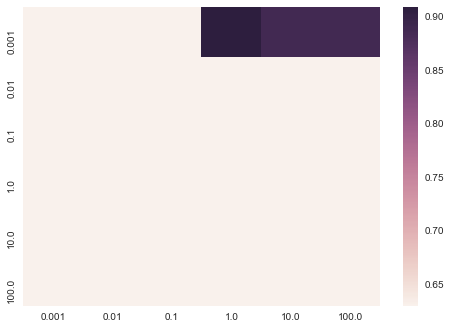

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                                                        cancer.target,
                                                                                        stratify = cancer.target,
                                                                                        random_state=0)

# ハイパーパラメータの全ての組み合わせでモデルを構築・検証
scores = {}
for gamma in np.logspace(-3, 2, num=6):
    for C in np.logspace(-3, 2, num=6):
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train,y_train)
        scores[(gamma, C)] = svm.score(X_test, y_test)

scores = pd.Series(scores)
print('ベストスコア:{:.2f}'.format(scores.max()))
print('その時のパラメータ(gamma, C):{}'.format(scores.idxmax()))
sns.heatmap(scores.unstack())

この結果から、ベストスコアは0.91、その時のパラメータは、gammaが0.001、Cが1.0であることがわかります。

#### モジュールの関数を使ってグリッドサーチする

仕組みが分かったところで、`sklearn.model_selection`モジュールの`GridSearchCV`クラスを用いて、同等の処理をする方法を説明します。プログラムは、次に示す通りです。

モデル評価用にテストデータを分離するところまでは先程と同様です。違うのは、学習用データを`GridSearchCV`クラスの`fit`メソッドに与えるところです。こうすることで、ハイパーパラメータの組み合わせについてモデルの評価が行なわれるだけでなく、ベストモデルの構築まで終了します。ベストモデルを実現するパラメータの組み合わせや評価結果は、属性値から取得できます。

ここで留意したいのは、`GridSearchCV`クラスの`fit`メソッドの実行時に行われるモデルの評価は、デフォルトではk分割交差検証（厳密にはその改良版）が使われるという点です。そのため`GridSearchCV`クラスには初期化パラメータcvがあり、ここではcv=5と設定しました。

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                                                        cancer.target,
                                                                                        stratify = cancer.target,
                                                                                        random_state=0)
param_grid = { 'C': np.logspace(-3, 2, num=6)
                          ,'gamma':np.logspace(-3, 2, num=6)}

gs = GridSearchCV(estimator=SVC(),
                                  param_grid=param_grid,
                                  cv=5)

gs.fit(X_train,y_train)

print('Best cross validation score:{:.3f}'.format(gs.best_score_))
print('Best parameters:{}'.format(gs.best_params_))
print('Test score:{:.3f}'.format(gs.score(X_test,y_test)))

Best cross validation score:0.930
Best parameters:{'C': 1.0, 'gamma': 0.001}
Test score:0.909


出力結果を見ると、グリッドサーチによって見つけられたモデルの評価スコア（0.93）、それを与えるハイパーパラメータの組み合わせ、テスト用データにおける評価スコア（0.91）がわかります。学習用データのk分割交差検証によって得られた評価スコアと、テスト用データのスコアが近いことから、過学習は生じていないと考えられます。

Scikit-learnではグリッドサーチの他にランダムサーチも用意されています。詳しくは`sklearn.model_selection`モジュールの`RandomizedSearchCV`クラスの使い方を参照してください。また、よりスマートなパラメータ探索としてベイズ最適化を活用したアプローチ（Hyperoptなど）もあります。

#### <練習問題 1>
乳がんデータに対して、決定木を使ってグリッドサーチと交差検証を実施せよ。なお、決定木のパラメータは、木の深さとリーフに含まれるべき最小サンプル数、具体的には、param_grid = {'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]}と設定すること。

### 13.1.3 パフォーマンスチューニング：特徴量の扱い
キーワード：特徴量エンジニアリング、特徴選択、特徴抽出

本節では、モデルのパフォーマンスチューニングを考える上で重要となる**特徴量（feature）**の扱いについて、以下２つの視点に立って説明します。

- 学習不足の場合（underfitting） 
- 過学習の場合（overfitting）

#### 学習不足の場合

モデルが過学習はしてないが精度も低い場合、つまり、そもそもの汎化性能が低いケースでは（underfitting）、一般的に、特徴量を増やせないかを検討します。新しくデータを収集し全く新しい特徴量を追加する、特徴量の計算期間にバリエーションを持たせる、特徴量同士の比率を追加するなどの工夫を凝らすということです。

#### 過学習の場合

過学習が疑われる場合は、上記の学習不足の場合とは逆に、特徴量の数を減らすことを検討するのが一般的です。データ数に対して特徴量の数が多いと汎化誤差の上限が高まるためです。これを次元の呪いと言います。
特徴量の数を削ることを**次元削減（dimension reduction）**と呼びます。次元削減は2つに分類されます。一つは特徴量のサブセットを選択する**特徴選択（feature selection）**、もう一つは元の特徴空間軸を別の空間軸に変換する**特徴抽出（feature extraction）**です。第12章で学んだ主成分分析（PCA）はこの特徴抽出の基本的手法として広く知られています。前者の特徴選択については、本書では詳細割愛しますが、`sklearn.model_selection`モジュールの`RFE`クラスや`RFECV`クラスで実行することができます。

どのような特徴量を生成するかを検討することを**特徴量エンジニアリング（feature engineering）**と言います。
特徴量エンジニアリングは画像、音声、自然言語、購買履歴などの構造データ、株価などの時系列データといったデータ構造別や、金融、医療、小売、マーケティング、人事、広告、製造といった業種ごとに知見が蓄積されています。現場に蓄積された知見の反映も大切にしましょう。また、次元削減についてはモデルの解釈が優先される場合は特徴選択を基本とするのがよいでしょう。

>[参考文献]

>『Introduction to Machine Learning with Pyton』（Andreas C.Muller & Sarah Guido、O'REILLY）

>『データサイエンス講義』（Rachel Schutt (著), Cathy O'Neil (著), 瀬戸山 雅人  (翻訳), 石井 弓美子 (翻訳), & 7 その他、オライリージャパン）

>『Building Machine Learning Systems with Python』（Willi Richert (著), Luis Pedro Coelho (著), 斎藤 康毅  (翻訳)、翻訳：実践機械学習システム、オイラリージャパン）

>『Python Machine Learning』（Sebastian Raschka、Packt Publishing Ltd.、翻訳：Python機械学習プログラミング）

### 13.1.4 モデルの種類
キーワード：プロファイリングモデル、予測モデル

本節ではモデルの種類について説明します。これまではモデリング対象となるデータの背景、特にデータ生成期間について、特段の注意を払ってきませんでした。教師あり学習のモデル構築のためには、当然、説明変数と目的変数を準備する必要がありますが、実はこれら変数の定義期間の違いで、モデルの種類を分けることができます。例えば、以下文献では、モデルを**プロファイリングモデル**と**予測モデル**の2つに分けています。

>[参考文献]

>『データマイニング手法 予測・スコアリング編―営業、マーケティング、CRMのための顧客分析』（ゴードン S.リノフ (著), マイケル J.A.ベリー (著), 佐藤 栄作 (翻訳), 斉藤 史朗 (翻訳)、海文堂出版）

>『データマイニング手法 探索的知識発見編―営業、マーケティング、CRMのための顧客分析』（ゴードン S.リノフ (著), マイケル J.A.ベリー (著), 佐藤 栄作 (翻訳), 斉藤 史朗 (翻訳)、海文堂出版）

プロファイリングモデルは、説明変数と目的変数とで、それぞれ同じ期間のデータで生成するモデルです。例えば、セールスマンを昨年度の営業成績上位10%とその他の2つに分け、同期間におけるセールスマンごとの各種アクティビティを説明変数とするといったようなケースです。一方、予測モデルは、説明変数と目的変数で期間が異なるもので、説明変数は目的変数よりも前の期間から生成されたデータを利用してモデリングするのが普通です。例えば、社員の入社から12ヶ月間の各種アクティビティを説明変数とし、入社後13-18ヶ月における退職有無を目的変数などとします。セールス＆マーケティングや人事領域におけるさまざまな予測モデル、優良顧客化予測、ブランド購買離反者予測、ブランドスイッチャー予測、新規商品購買者予測、退職者予測、ハイパフォーマー予測などは、基本的には予測モデル型として説明変数と目的変数が設計されます。同じ機械学習のアルゴリズムであっても、分析の目的が対象データの探索的理解なのか予測モデル構築なのかで、準備すべきデータの生成が変わることを理解しましょう。

## 13.2 モデルの評価指標
ゴール：混同行列とROC曲線を理解し、分類モデルの評価指標を説明できるようになる。

モデル性能の評価はさまざまな評価指標によって定義できます。本節では、主に分類モデルの評価指標について学びます。具体的には、**適合率（precision）**、**再現率（recall）**、**F1スコア（F1-measure）**、**AUC（Area Under Curve）**について学びます。また、これらの評価指標を理解するために不可欠な**混同行列（confusion matrix）**と**ROC曲線**についても学びます。最後に、回帰アルゴリズムの評価指標について簡単に紹介します。

### 13.2.1 分類モデルの評価：混同行列と関連指標
キーワード：混同行列、正解率、適合率、再現率、F1スコア

モデルの評価については、これまで主に正解率に主眼をおいてきましたが、モデルの性能を測る指標は正解率の他にも様々なものが存在します。それらの指標を理解するため、まずは**混同行列（confusion matrix）**を紹介します。

混同行列は分類モデルの評価を考える際の基本となる行列で、モデルの予測値と観測値の関係を表したものです。具体的には以下の図のように4つにの区分を持ちます。予測値が正例（positive）か負例（negative）が列に、観測値が正例か負例が行に並んでいます。予測値の値が各セルの名称の元となり、観測値との整合性からtrueかfalseに分けられています。

||負例（予測）|正例（予測）|
|:------|------:|------:|
| 負例（実績） | True negative(TN) | False positive(FP)|
|正例（実績）  | False negative(FN)| True positive(TP)|

#### 混同行列の実例

第11章、第12章で扱った乳がんデータ（cancerデータ）を使って、混同行列の取得方法を説明します。まずは次のように、サポートベクターマシンとして分類モデルを構築します。

この分類モデルは、乳がんであるクラスタか、そうでないクラスタかを「0」か「1」のどちらかの値で返します。

In [5]:
from sklearn.svm import SVC

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                                                        cancer.target,
                                                                                        stratify=cancer.target,
                                                                                        random_state=66)
model = SVC(gamma=0.001,C=1)
model.fit(X_train,y_train)

print('{} train score: {:.3f}'.format(model.__class__.__name__, model.score(X_train,y_train)))
print('{} test score: {:.3f}'.format(model.__class__.__name__ , model.score(X_test,y_test)))

SVC train score: 0.979
SVC test score: 0.909


混同行列は、`sklearn.metrics`モジュールの`confusion_matrix`関数で取得できます。数値の並びは先の図で記した通り、列に予測値（y_pred）、行に観測値（y_test）が、負例・正例の順に並びます。

In [6]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
m = confusion_matrix(y_test, y_pred)
print('Confution matrix:\n{}'.format(m))

Confution matrix:
[[48  5]
 [ 8 82]]


以下、この混同行列を使って、**正解率（accuracy）**、**適合率（precision）**、**再現率（recall）**、**F1スコア（f1 score）**ついて説明します。

|| 予測(0)|予測(1)|
|:------|------:|------:|
| 観測(0) |48|5|
| 観測(1) |8|82|

#### 正解率

正解率は、全体に対して予測が当たった割合です。これまで正解率はScikit-learnの各クラスのscoreメソッドを使って計算してきましたが、混同行列を使うと以下のように計算できます。scoreメソッドの結果と同じ値になっていることを確認しましょう。

In [7]:
accuracy = (m[0, 0] + m[1, 1]) / m.sum()
print('正解率:{:.3f}'.format(accuracy))

正解率:0.909


計算式からわかる通り、目的変数を0と予測して観測値が0であった数(48)と、1と予測して観測値が1であった数（82）の合計(48+82=130)を、行列全体の数(143)で割った値になっています。全体として、どれだけ1と0を正確に予測できているかを見る指標が正解率です。

#### 適合率、再現率、F1スコア

適合率、再現率は、異なる視点からモデルの評価を可能にします。

**適合率**は、1と予測した中で実際にどれだけ1であったかの割合です。異常検知システムがアラートを出した回数のうち、実際に異常であった割合などを想像してください。

**再現率**は、実際は1のデータのうち正しく1と予測できた割合です。例えば、病気の診断システムで再現率100%とは、実際の病気データについて全て病気であると予測できている状態です。

**F1スコア**は適合率と再現率の調和平均です。適合率を優先すべきか、再現率を優先すべきかが決まっていない時点で、モデルを総合的に評価する場合などに使われます。

以上の3指標の算出を混同行列の要素を使って表現すると以下のようになります。

In [8]:
precision = (m[1,1])/m[:, 1].sum()
recall = (m[1,1])/m[1, :].sum()
f1 = 2 * (precision * recall)/(precision + recall)

print('適合率:{:.3f}'.format(precision))
print('再現率:{:.3f}'.format(recall))
print('F1値:{:.3f}'.format(f1))

適合率:0.943
再現率:0.911
F1値:0.927


これらの値は、Scikit-learnの関数を使って求めることもでき、そのほうが簡単です。上記と数値が一致していることを確認してください。

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('適合率:{:.3f}'.format(precision_score(y_test, y_pred)))
print('再現率:{:.3f}'.format(recall_score(y_test, y_pred)))
print('F1値:{:.3f}'.format(f1_score(y_test, y_pred)))

適合率:0.943
再現率:0.911
F1値:0.927


#### <練習問題 1>
乳がんデータに対して、サポートベクターマシン以外のモデル（ロジスティック回帰分析など）を構築し、混同行列を作ってください。また、テストデータにおける正解率、適合率、再現率、F1値の値をScikit-learnの関数を使って取得して下さい。

### 13.2.2 分類モデルの評価：ROC曲線とAUC
キーワード：ROC曲線、AUC

前節で学んだ混同行列は、予測結果が正例と負例にラベル付けされていることを前提としますが、モデルの評価時点において、予測ラベルを分ける閾値が事前に決定できるとは限りません。つまり、分類モデルが出力する（予測ラベルではなく）予測確率の値そのものと観測値（1か0か）との関係から、モデルの性能を評価したい場合があり、そのような場合、本節で学ぶ**ROC曲線**と**AUC**が役に立ちます。

#### ROC曲線

ROC曲線は、縦軸に**真陽性率（TP: true positive rate）**、横軸に**偽陽性率（FP: false positive rate）**の値をプロットした曲線です。

真陽性率とは、実際の正例のうちどれだけを正例と予測できたかの割合（再現率と同じ）、偽陽性率とは、実際は負例のうち正例と予測されてしまった割合です。予測確率を予測ラベルに変換する際の閾値を0.0と1.0の間で徐々に変化させ、真陽性率と偽陽性率の関係をプロットすることでROC曲線を描けます。

#### 予測確率を閾値で分けて予測ラベルを作る
閾値を変化させてROC曲線を描くとはどういうことか理解するため、乳がんデータを使って確認してみましょう。次のプログラムは、ロジスティック回帰モデルを扱う`LogisticRegression`クラスの`predict_proba`メソッドを使って、癌が良性（benign：1）か悪性（malignant：0）かの予測確率を取得するものです。`predict_proba`メソッドの出力は0か1かのラベルではなく、各クラスに分類される予測確率の配列です。

In [10]:
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                                                        cancer.target,
                                                                                        stratify = cancer.target,
                                                                                        random_state=66)
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

results = pd.DataFrame(model.predict_proba(X_test), columns=cancer.target_names)
results.head()

,malignant,benign
0,0.003626,0.996374
1,0.000492,0.999508
2,0.030050,0.969950
3,0.006849,0.993151
4,0.003181,0.996819


予測確率から予測ラベル分け（「malignant：0」か「benign：1」）するには、単純に50%（0.5）を閾値として、それを超えるかどうかで判断できそうですが、実際はモデルの使用目的、正例の自然発生率などを考慮して閾値を設定します。

閾値を変えれば、当然、良性（正例）と予測されるサンプルの数も変わるので、正解率、適合率、再現率も変わります。例えば、以下のように、閾値を0.4、0.3、0.15、0.05と4パターンの場合を考えてみます。現在、正例である良性（benign）クラスの予測確率に注目します。以下では、良性の予測確率が閾値を超えていたら1、そうでなければ0となるフラグ変数を作成しています。

In [11]:
for threshold in [0.4, 0.3, 0.15, 0.05]:
    results[f'flag_{threshold}'] = results['benign'].map(lambda x: 1 if x > threshold else 0)
results.head(10)

,malignant,benign,flag_0.4,flag_0.3,flag_0.15,flag_0.05
0,0.003626,0.996374,1,1,1,1
1,0.000492,0.999508,1,1,1,1
2,0.030050,0.969950,1,1,1,1
3,0.006849,0.993151,1,1,1,1
4,0.003181,0.996819,1,1,1,1
5,0.008824,0.991176,1,1,1,1
6,0.005871,0.994129,1,1,1,1
7,0.002913,0.997087,1,1,1,1
8,0.923066,0.076934,0,0,0,1
9,0.846883,0.153117,0,0,1,1


上記の9行目や10行目（インデックス8と9）を見ると、予測確率とフラグの関係が理解しやすいと思います。このように、予測確率と閾値から予測フラグを立てることで、観測値との混同行列が作成可能となり、偽陽性率と真陽性率の値を（閾値ごとに）算出できます。

#### ROE曲線をプロットする

上記閾値の4パターンだけではROC曲線のごく一部しか表現できないため、以下では、閾値を0.01から0.99の間で50通りとして、偽陽性率と真陽性率をプロットしてみます。labelsで取得している結果が上記で確認した予測フラグです。

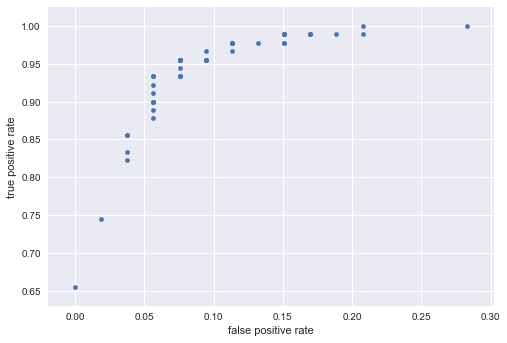

In [12]:
rates = {}
for threshold in np.linspace(0.01, 0.99, num=50):
    labels = results['benign'].map(lambda x: 1 if x > threshold else 0)
    m = confusion_matrix(y_test, labels)
    rates[threshold] = {'false positive rate': m[0,1] / m[0, :].sum(),
                                      'true positive rate': m[1,1] / m[1, :].sum()}
pd.DataFrame(rates).T.plot.scatter('false positive rate', 'true positive rate')

#### ROE曲線とAUC

ROC曲線は、Scikit-learnのクラスを使っても描画できます。具体的には、`sklearn.metrics`モジュールの`roc_curve`関数を使います。

ここでは同じく乳がんデータを使ってサポートベクターマシンのモデルを構築し、予想確率（y_pred）を得ます。

In [13]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size=0.5, random_state=66)

# SVCによる予測確率の取得
model = svm.SVC(kernel='linear', probability=True, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

予測確率（y_pred）を得たら観測値（y_test）と共に`sklearn.metrics`モジュールの`roc_curve`関数に与えます。すると、偽陽性率（fprとする）と真陽性率（tprとする）の各配列を戻り値として取得できるので、それを描画します。

#### AUCの計算

ここではさらにAUCも計算してみます。AUCの値は`sklearn.metaucs`モジュールの`auc`関数にfprとtprをこの順に与えると取得できます。
ROC曲線は、AUC計算で使ったfprとtprの各配列を使って描画します。赤い実線がそれに相当します。ここでは予測スコアがランダムな場合のROE曲線も合わせて描画しています。黒い点線がそれに相当します。

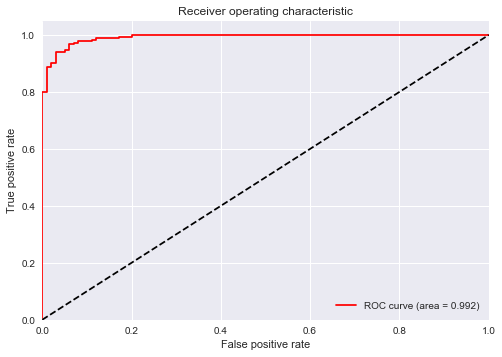

In [14]:
# AUCの算出
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

# ROC曲線の描画
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %.3f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")

#### 理想的なROE曲線とAUC

ROC曲線の形状は、閾値を（1.0を超える値から）徐々に小さくしたとき、原点から真陽性率だけが上昇するのが理想です。つまり、原点から座標(0,1)に向けて垂直移動し、その後、座標 (1,1)に水平移動するものが最適理想曲線となります。

逆に、予測確率がランダムな場合、真陽性率も偽陽性率も等しく上昇することが期待されるので、ROC曲線は原点から傾き1の直線となります。機械学習によって構築されたモデルは、通常、ランダムな場合と最適理想曲線の間にプロットされ、より膨らみを持つことが期待されます。

AUCはROC曲線の形状に基づくモデルの評価指標のことで、ROC曲線と横軸で囲まれる面積の値です。つまり、最適理想曲線では1.0、予測確率がランダムな場合は0.5となります。

上記より、本ケースのAUCは0.988であることから、ランダムと比べると、かなり高い性能を有したモデルであると確認できます。

>[参考文献]

>『戦略的データサイエンス入門 ―ビジネスに活かすコンセプトとテクニック』（Foster Provost (著), Tom Fawcett (著), 竹田 正和(監訳) (翻訳), 古畠 敦 (翻訳)、オライリージャパン）

混同行列の作成、ROC曲線の形状比較、そして適合率、再現率、F1スコア、AUCの大小比較は、モデル選択をする際の基礎的な根拠となります。ただし、あくまでもそれは選択候補モデル間に、相対的な順番を与えるものに過ぎませんから、モデルを活用したときに得られであろうビジネス成果との関係を理解することなく、単なる数値追求だけとなることは避けるよう留意しましょう。

#### 不均衡データ下におけるAUCの活用

最後に、AUC活用の意義を補足します。本節冒頭では、閾値が不明瞭な段階では混同行列が一意に定まらない点を指摘しました。

AUCを活用すると、不均衡データ（imbalanced data）に対応できます。例えば、あるスーパーで商品Aを買う人が全体の5%だったとします。予測モデルを構築し、予測確率上位5人が商品Aを買うと予測フラグ立てされるとしましょう。このとき、買うと予測された5人（フラグ1の人）のいずれも正解ではなかった（未購買であった）とします。混同行列に当てはめると以下のようなケースです。

|| 予測(0)|予測(1)|
|:------|------:|------:|
| 観測(0) |90|5|
| 観測(1) |5|0|

この場合、適合率は0%ですが、正解率は90％となります。もしモデルの精度を正解率だけでみると、90%の正解率は一見良さそうなモデルに見えてしまいます。しかし、予測したい人は買う人ですから、適合率0%のモデルは、意味のあるモデリング結果とは言えません。

この例のように「買う人が5人」「買わない人が90人」といった、それぞれのクラスのサンプル数に偏りがある状況下では、正解率は好ましい指標とは言えません。その点、AUCであれば、各クラスのサンプル数の偏りは、fprとtprの分母として使われるため吸収されます。つまり、AUCは不均衡データ下におけるモデルの評価時にも耐えられる指標と言えます。

#### <練習問題 1>
アヤメのデータ（iris）に対して、モデリングを実施し（目的変数はiris.target）、ROC曲線とAUCを計算せよ。他クラス分類問題のため、`sklearn.multiclass`モジュールの`OneVsRestClassifier`クラスの使い方を確認すること。

### 13.2.3 回帰モデルの評価指標
キーワード：MSE、MAE、MedAE、R2スコア

本節では、回帰モデルの評価指標について紹介します。

回帰モデルは訓練データの目的変数が株価や物件価格などの数値であるため、比較的直感的な指標でモデルを評価することができます。主な評価指標は、以下の通りです。

#### 平均二乗誤差（Mean Squared Error：MSE）
予測値と正解の差（残差）の二乗をサンプルごとに足し上げ（これを残差平方和（sum of squared errors：SSE）と言います）、最後にサンプル数で割ることで得られるものが平均二乗誤差MSEです。MSEはシンプルでわかりやすい指標のため、様々なアルゴリズムの性能評価に使用されます。

#### 平均絶対誤差（Mean Absolute Error：MAE)
残差の絶対値をサンプルごとに足し上げ、最後にサンプル数で割ることで得られるのが平均絶対誤差MAEです。MSEと比べ残差が二乗されていない分、（予測の）外れ値の影響を受けにくいという特徴があります。

#### Median Absolute Error（MedAE）
残差の絶対値の中央値がMedAEです。MAEよりも更に外れ値に堅牢（ロバスト）な評価指標です。

#### 決定係数（R2）
決定係数（$R^{2}$）は、検証データの平均値で予測をした場合の残差平方和SST（sum of squared total）と、モデルの残差平方和SSE（sum of squared errors）の比率で、$R^{2}=1-SSE/SST$と定義されます。平均値予測という最もナイーブな予測に対して二乗誤差をどれだけ削れたかを示す指標で、誤差を全てなくせれば1.0、平均値予測と同等で0.0になります。$R^{2}$の範囲は、通常0〜１の値を取るが、負になる可能性があることを留意しましょう。

#### 回帰モデル評価の実例

それでは回帰用のサンプルデータセットであるHousingデータセットを使って、回帰モデルの評価指標の取得方法を見ていきましょう。

Housingデータセットは、ボストン近郊地域に関するエリア属性（犯罪発生率や低所得者の割合など）と住宅価格の中央値（MEDV）を変数として持っています。データの先頭5行を表示した結果は、次の通りです。

In [15]:
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target, name='MEDV')
X.join(y).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


以下では、このMEDVを目的変数として「重回帰モデル（LinearRegression）」「リッジ回帰モデル（Ridge）」「決定木モデル（DecisionTreeRegressor）」「XXXXX（LinearSVR）」でモデリングし、それぞれのモデルに対してMAE、MSE、MedAE、R2の各評価値を算出するプログラムです。評価にはホールドアウト法を採用しました。

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

models = {
    'multi-linear': LinearRegression(),
    'ridge': Ridge(random_state=0),
    'tree': DecisionTreeRegressor(random_state=0),
    'svr': LinearSVR(random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'MSE')] = mean_squared_error(y_test, model.predict(X_test))
    scores[(model_name, 'MAE')] = mean_absolute_error(y_test, model.predict(X_test))
    scores[(model_name, 'MedAE')] = median_absolute_error(y_test, model.predict(X_test))
    scores[(model_name, 'R2')] = r2_score(y_test, model.predict(X_test))

pd.Series(scores).unstack()

,MAE,MSE,MedAE,R2
multi-linear,3.632643,25.309383,2.903830,0.666170
ridge,3.623009,25.290962,2.930524,0.666413
svr,3.283581,26.825666,2.076328,0.646170
tree,3.062055,24.612134,2.100000,0.675367


なお上記では、ホールドアウト法において評価指標を取得していますが、もちろん交差検証においても各評価指標を取得することができます。k分割交差検証の場合は、それを行うためのcross_val_score関数にある引数scoringを設定することで戻り値を変更できます。詳しくはScikit-learnの公式ドキュメントを確認してください。

## 13.3 アンサンブル学習
ゴール：アンサンブル学習の全体像と代表的手法（ランダムフォレスト、勾配ブースティング）を使えるようになること

第11章では、教師あり学習の様々なアルゴリズム（決定木、ロジスティック回帰、サポートベクターマシーンなど）を個別に学びましたが、ここでは複数のモデルを組み合わせて予測する**アンサンブル学習（ensemble learning）**について学びます。具体的には**バギング（bagging）**、**ブースティング（boosting）**について学びます。またバギングとブースティングの中でも代表的なアルゴリズムとして**ランダムフォレスト（Random Forest）**と**勾配ブースティング（Gradient Boosting）**について学びます。個別のアルゴリズムのチューニングでは突破できない性能を、アンサンブル学習では実現できる可能性があります。精度追求が重要な局面においてアンサンブル学習は重要な一つのオプションとなり得ます。

### 13.3.1 バギング
キーワード：バギング、ブートストラップ

**バギング（bootstrap aggregating: bagging）**は、まず元の訓練データ（n行）からランダムにn行のデータを復元抽出（重複を許して抽出）し、新しい訓練データを作成するということを繰り返します（ブートストラップと言います）。そして、その各標本に対して一つ一つモデルを作成し、モデルの結果を集約して予測をします。結果の集約は分類であれば多数決、回帰であれば平均値を取るなどします。元の訓練データと少しずつ異なる訓練データに対してモデルが構築されるので、モデルが過学習傾向にある時、バギングによって汎化性能を向上させられる可能性があります。

#### バギングの実例

以下がバギングの実行例になります。乳がんのデータを使ってk-NNモデルでバギングしてモデリングする例です。`sklearn.ensemble`モジュールの`BaggingClassifier`クラスを使っています（回帰用のクラスもあるので、Scikit-learnの公式ドキュメントを確認ください）。

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify = cancer.target, random_state=66)

models = {
    'kNN': KNeighborsClassifier(),
    'bagging': BaggingClassifier(KNeighborsClassifier(), n_estimators=100, random_state=0) 
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
bagging,0.937063,0.950704
kNN,0.923077,0.948357


上記では引数`n_estimators`を100として、kNNのモデルを100個でバギングしています。訓練スコア（train_score）はほぼ同等ですが、テストスコア（test_score）が上昇していることを確認できます。

`BaggingClassifier`クラスは他にmax_samples(デフォルトは1.0)、max_features（デフォルトは1.0）というパラメータを持ちます。前者はブートストラップサンプルをする時に元のデータの何割抽出するかを指定します。0.5とすれば元の訓練データが100件あれば50件の標本が抽出されます。後者は説明変数のサンプリングで、0.5とすれば全変数のうちの半分でモデルが学習されます。

元のモデルが過学習しているときは、手元のデータをそのまま全て使わないようにし、説明変数に（標本ごとに）多様性を与えるようにすることで、有効な過学習対策になる可能性があることを覚えておきましょう。

#### <練習問題 1>
アヤメのデータセットを対象にバギングを使って、目的変数(iris.target)を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

### 13.3.2 ブースティング
キーワード：ブースティング、アダブースト

前節のバギングでは、ブートストラップによって抽出された複数の標本に対して（個別に）複数のモデルが構築されます。一方、本節で学ぶ**ブースティング（boosting）**は、訓練データもモデルも逐次的に生成・構築されていきます。

もう少し詳細に述べると、まずオリジナルの訓練データに対し最初のモデルが構築されます。この時点で予測と正解を比較して合致しているサンプル、外しているサンプルを把握します。そして外したサンプルが、次のモデリング段階で重視されるように新しい訓練データが生成されます。このようなステップが繰り返される過程でモデルも逐次的に複数構築されるのです。最後に、それらの予測値を組み合わせることで汎化性能の向上が図られます。なお、ブースティングは学習不足（underfitting）傾向の時に効果的な手法と言われています。

#### ブースティングの実例

ブースティングの実例を示します。決定木モデル（DecisionTreeRegressor）をブースティングするものです。ブースティングには、`sklearn.ensemble`モジュールの`AdaBoostRegressor`クラスの使います。

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=66)

models = {
    'tree': DecisionTreeRegressor(random_state=0),
    'AdaBoost': AdaBoostRegressor(DecisionTreeRegressor(), random_state=0) 
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.926081,0.999413
tree,0.692137,1.000000


決定木を単体で使う場合テストスコアは約0.69止まりですが、アダブーストを使ったアンサンブル学習に切り替えるとテストスコアが約0.93と大きく向上していることがわかります。このようにアンサンブル学習は精度追求局面においては大変強力なオプションになり得ることを覚えておきましょう。

ただし今回のアダブーストの結果は、やや過学習傾向にある点は留意すべきでしょう。

>**[やってみよう]**

>アダブーストについてのパラメータについて調べてみましょう。上の過学習を防ぐために、どうやってパラメータを設定しますか。

#### <練習問題 1>
アヤメのデータセットを対象にブースティング（アダブースト）を使って、目的変数(iris.target)を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

### 13.3.3 ランダムフォレスト、勾配ブースティング
キーワード：ランダムフォレスト、勾配ブースティング、変数の重要度

本節では、バギングとブースティングの中でも代表的なものである**ランダムフォレスト（Random Forest）**と**勾配ブースティング（Gradient Boosting）**の使い方を紹介します。いずれも、ベースとしている学習器は決定木です。

アンサンブル学習を手軽に実行する場合、いずれかのアルゴリズムが採用されるケースが多いです。機械学習の初学者であれば、考え方を前節と前々節で理解し、実際のモデリングはこれらアルゴリズムで行うというスタートが良いと思われます。

またモデル結果の解釈性が優先される場合は、ロジスティック回帰や決定木など、よりシンプルなモデルを採用した方が良い局面もあることは留意しておきましょう。

#### ランダムフォレストと勾配ブースティングの実例

実際にランダムフォレストと勾配ブースティングを使ったプログラム例をしみします。データはHousingデータを使いました。

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=66)

models = {
    'RandomForest': RandomForestRegressor(random_state=0),
    'GradientBoost': GradientBoostingRegressor(random_state=0) 
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,0.921616,0.976947
RandomForest,0.844031,0.969487


#### 変数の重要度

上記の結果から、Housingデータに対しては、勾配ブースティングの性能が高そうであることがわかります。

先に、アンサンブル学習のモデルの解釈性（の低さ）について言及しましたが、モデリングの中でどの変数が重要な役割を担ったかを定量的に把握することができます。具体的には各オブジェクトが持つ`feature_importmnces`属性にアクセスすることで、**変数の重要度（feature importance）**を取得することができます。実際に取得すると、次のようになります。

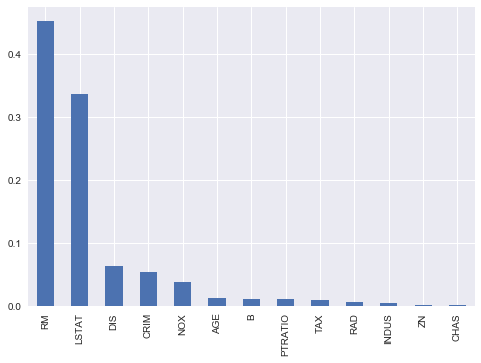

In [20]:
s = pd.Series(models['RandomForest'].feature_importances_,
              index=boston.feature_names)
s.sort_values(ascending=False).plot.bar(color='C0')

変数の重要度は情報利得をベースに計算されています。そのため変数の重要度を見ても回帰係数のような解釈は困難です。ただし、相対的な大小関係から、どの変数がモデリングにおいて重要であったかは示してくれますし、この変数が効果的であろうという直感と整合的な結果になることも少なくありませんから、確認する癖を付けておくことは大切です。

また、重要変数に絞り、説明変数と目的変数の関係を深堀りすれば、それがなぜモデリングに役立ったか考察することもできます。

本書では割愛しますが、Partial Dependence Plots（PDP）という、説明変数の大小と予測値の大小関係性を図解してくれる関数も存在します。Scikit-learnでは`plot_partial_dependence`関数が用意されていますので、更に理解を深めたい方は公式ドキュメントを参照ください。

### 13.3.4　今後の学習に向けて
最後に、今後の学習のための参考書を紹介します。後半は少し難易度がある機械学習の本で、より理論的な知識や実装を身につけたい方には以下がオススメです。ある程度数学的なバックグランドも必要ですが、この講座を終えた後であれば大丈夫だと思います。

>[参考文献]

>『はじめてのパターン認識』（平井 有三 (著)、森北出版）

>『Python Machine Learning』（Sebastian Raschka、Packt Publishing Ltd.、翻訳：Python機械学習プログラミング）

>『Hands-On Machine Learning With Scikit-Learn and Tensorflow: Concepts, Aurelien Geron (著),Oreilly & Associates Inc）

>『Python for Probability, Statistics, and Machine Learning』（Jose Unpingco、翻訳：科学技術計算のためのPython＜確率・統計・機械学習＞）

上記はどちらかというと比較的数式が多く、あまりビジネス的な視点では多くは書かれていません。以下の参考文献は、ビジネスでデータサイエンスを活かす視点で記載されていますので、ぜひ参考にしてください。

>[参考文献]

>『戦略的データサイエンス入門 ―ビジネスに活かすコンセプトとテクニック』（Foster Provost (著), Tom Fawcett (著), 竹田 正和(監訳) (翻訳), 古畠 敦 (翻訳)、オライリージャパン）

>『データサイエンス講義』（Rachel Schutt (著), Cathy O'Neil (著), 瀬戸山 雅人  (翻訳), 石井 弓美子 (翻訳), & 7 その他、オライリージャパン）

>『データ分析プロジェクトの手引: データの前処理から予測モデルの運用までを俯瞰する20章』（David Nettleton (著), 市川 太祐 (翻訳), 島田 直希 (翻訳)、共立出版）

>『Machine Learning実践の極意 機械学習システム構築の勘所をつかむ!』（Henrik Brink  (著),Joseph W. Richards (著),Mark Fetherolf (著),&その他、インプレス）

>『Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies (MIT Press) 』（John D. Kelleher  (著), Brian Mac Namee  (著), Aoife D'Arcy  (著), The MIT Press ）

>[参考URL]

>http://scikit-learn.org/stable/modules/ensemble.html

>https://xgboost.readthedocs.io/en/latest/

>https://lightgbm.readthedocs.io/en/latest/

>https://tech.yandex.com/catboost/doc/dg/concepts/about-docpage/

#### <練習問題 1>
アヤメのデータを対象にランダムフォレストと勾配ブースティングを使って、目的変数(iris.target)を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

## 13.4 総合問題

### 13.4.1 総合問題1

以下の用語について、それぞれの役割やその意味について述べてください。
- 過学習
- ホールドアウト法
- 交差検証法
- グリッドサーチ
- 特徴量
- 特徴選択
- 特徴抽出
- 混同行列
- ROC曲線
- 適合率
- 再現率
- 正解率
- F1スコア
- 真陽性率（True Positive Rate）
- 偽陽性率（False Positive Rate）
- AUC
- EMアルゴリズム
- ジャックナイフ法
- ブートストラップ法
- アンサンブル学習
- バギング
- ブースティング
- ランダムフォレスト

### 13.4.2 総合問題2

乳がんデータセットを使って、予測モデル（ロジスティック回帰、SVM、決定木、k-NN、ランダムフォレスト、勾配ブースティング）を構築し交差検証（5分割）により、どのモデルが一番良いか確認してください。